# Binary classfication

In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn import model_selection
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

### Home task: Spam detection

Для заданной тестовой выборки построить модель для предсказания является ли sms сообщение спамом.  
На заданном разбиении (df_train, df_test) ваша модель должна превзойти baseline'ы, приведенные ниже.  

Чем больше baseline'ов вы превзойдете, тем выше ваша оценка
Метрика качества F1


baseline 1: 0.9444      bag of words + Multinomial Naive Bayes  
baseline 2: 0.9490      symbol 3-grams with IDF and l2-norm + Logistic Regression  
baseline 3: 0.9636      text stemming + baseline 2  

**BASELINE 4: 0.965517241379 symbol 3-grams with IDF and l2-norm & filtering by capslock/number/links + Logistic Regression **


! Your results must be reproducible. Если ваша модель - стохастическая (как например LogisticRegression), то вы явно должны задавать все seed и random_state в параметрах моделей  
! Вы должны использовать df_test только для измерения качества конечной обученной модели. 

In [4]:
#load dataset
df = pd.read_csv('spam.csv', encoding='latin-1')
df = df[['v1', 'v2']]
df = df.rename(columns={'v1': 'target', 'v2': 'text'})
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
# dataset size
df.shape

(5572, 2)

In [6]:
# class proportions
df.target.value_counts(normalize=True)

ham     0.865937
spam    0.134063
Name: target, dtype: float64

In [7]:
# Use  df_train for model training
# Use df_test as  hold-out dataset for your final model perfomance estimation.
# You cannot change  this splitting
# All results must be reproducible
SEED = 1337
df_train, df_test = model_selection.train_test_split(df, test_size=0.4, random_state=SEED, shuffle=True, stratify=df.target)
print('train size %d, test size %d' % (df_train.shape[0], df_test.shape[0]))

train size 3343, test size 2229


In [20]:
#baseline 4
'''
symbol 3-grams with IDF and l2-norm & filtering by capslock/number/links + Logistic Regression 

'''
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.ensemble import VotingClassifier
import string
import re



vec_chars = TfidfVectorizer(lowercase=True, analyzer='char', ngram_range=(3,3), norm='l2', 
                            use_idf=True, smooth_idf=True)

#vec_lemmas = TfidfVectorizer(lowercase=True, analyzer='char', ngram_range=(3,3), 
#                          min_df=10, # exclude 3-grams appeared in less then 10 messages. 
#                          use_idf=True)

def by_specialexpr(df):
    matr = []
    for line in df:
        if re.search('[A-Z2-9@\%\$]{2,}', line) != None or re.search('[a-zA-Z2-9@]*\.[a-z]{2,3}', line) != None:
            matr.append([1])
        else:
            matr.append([0])
    
    return csr_matrix(np.matrix(matr))        
            


def by_chars(vec):
    # builds binary feature matrix by character n-gramms without stemming   
    bychars_X = vec.fit_transform(df_train.text)    
    return bychars_X
    


X3 = by_specialexpr(df_train.text)   
X2 = by_chars(vec_chars)

  
X = hstack([X2, X3])
print('feature matrix shape', X.shape)

#encode labels
label_enc = LabelEncoder().fit(df_train.target)
y_train = label_enc.transform(df_train.target)



#Logistic regression + optimize  hyperparams
grid = GridSearchCV(LogisticRegression(random_state=SEED), 
                   param_grid={'C': np.logspace(0,5,10), 
                               'penalty': ['l1', 'l2']}, 
                    scoring='f1', n_jobs=-1, cv=5, verbose=True, return_train_score=True)
grid.fit(X, y_train)
print('best params 2', grid.best_params_)
print('best estimator 2', grid.best_score_)
model = grid.best_estimator_
print('train', metrics.f1_score(y_train, model.predict(X)))


 
X_test = hstack([vec_chars.transform(df_test.text), by_specialexpr(df_test.text)])
y_pred = model.predict(X_test)
y_test = label_enc.transform(df_test.target)
print('test', metrics.f1_score(y_test, model.predict(X_test)))



feature matrix shape (3343, 11831)
Fitting 5 folds for each of 40 candidates, totalling 200 fits


/home/mmtsfasman/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/mmtsfasman/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/mmtsfasman/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/mmtsfasman/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/mmtsfasman/anaconda3/lib/python3.6/sit

/home/mmtsfasman/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/mmtsfasman/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/mmtsfasman/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/mmtsfasman/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/mmtsfasman/anaconda3/lib/python3.6/sit

best params 2 {'C': 2069.1380811147901, 'penalty': 'l2'}
best estimator 2 0.957419721906
train 1.0
test 0.965517241379


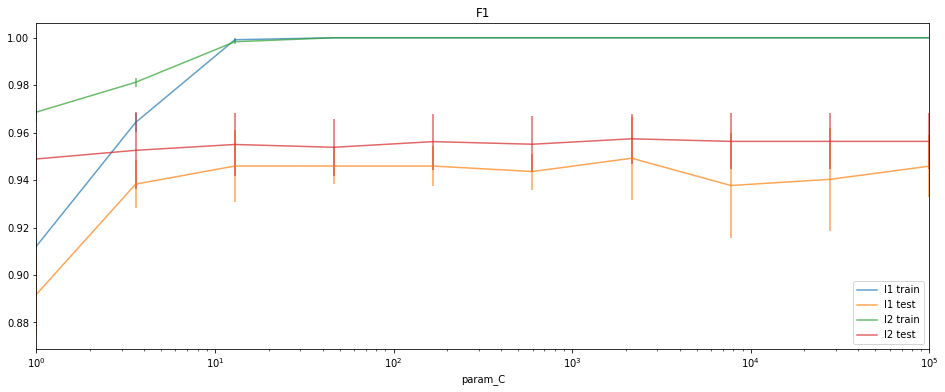

In [105]:
# validation curves
grid_df = pd.DataFrame(grid.cv_results_);
grid_df = grid_df[['param_C', 'param_penalty', 'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']]
fig, ax = plt.subplots(figsize=(16,6))
for label, df in grid_df.groupby('param_penalty'):
    df.plot(x='param_C', y='mean_train_score', yerr='std_train_score', logx=True, label=label + ' train',
            alpha=0.7,
            ax=ax)
    df.plot(x='param_C', y='mean_test_score', yerr='std_test_score', logx=True, label=label + ' test',
            alpha=0.7,
            ax=ax)
    plt.title('F1')